In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 7 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [3]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [13]:
df = df_raw.copy()
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() >= 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
print(len(df))

# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]

df = df.sample(250, random_state=0)
print(len(df))

def flatten(xss):
    return [x for xs in xss for x in xs]

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_evidence_single"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_evidence_redundant"] = df.apply(lambda r: r["sents_evidence_single"] + " " + df[df['title'] != r['title']].sample(1, random_state=0)["sents_complete"].values[0], axis=1)
df["sents_evidence_doc"] = df.apply(lambda r: r["sents_evidence_single"] + " " + r["sents_complete"], axis=1)

sents_cols = []
### evidence > evidence + redundant long text
sents_cols.append(f"sents_evidence_single")
# sents_cols.append(f"sents_evidence_redundant")  # 35
sents_cols.append(f"sents_evidence_doc")  # 17

print(df.iloc[0]["sents_evidence_redundant"])
df.sample(2)

2262
250
The film premiered at the 23rd Cannes Film Festival and was released theatrically in the United States on December 10 , 1969 . " Two Doors Down " was a song written and performed by Dolly Parton , which provided a 1978 U.S. country and pop hit for her . The song was sung from the perspective of a woman who has just broken up with her boyfriend and is debating attending a party two doors down the hall from her apartment . She decides to go , meets a new man and returns with him to her own apartment " two doors down " . It was included on Parton 's 1977 Here You Come Again album , but before Parton could release it as the album 's second single in March 1978 , singer Zella Lehr released a cover version that became a top ten U.S. country hit . While Lehr 's version was on the country charts , the title cut of Here You Come Again was becoming a much bigger pop hit than Parton had anticipated . Wanting to capitalize on her newfound pop success ( and also not wanting to compete with

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_complete,sents_evidence_single,sents_evidence_redundant,sents_evidence_doc
3492,test15937,Who is the employer of Martti Ahtisaari?,[Contact Group (Balkans)],"{'Contact Group (Balkans)': {'text': 'The Contact Group is the name for an informal grouping of great powers that have a significant interest in policy developments in the Balkans . The Contact Group is composed of United States , United Kingdom , Fran...","{'len': 1000, 'max': 400.8905029296875, 'min': 386.2033386230469, 'std': 1.1716729253248275, 'mean': 387.33526940917966, 'median': 387.02734375}",{'Contact Group (Balkans)': None},"{'Martti Ahtisaari': 400.8905029296875, 'Martti Aiha': 396.685791015625, 'Martti Löfberg': 394.449462890625, 'Martti Suosalo': 392.8753356933594, 'Merikukka Forsius': 392.5470886230469, 'Sari Baldauf': 392.3477783203125, 'Mart Siimann': 392.34237670898...","{'Martti Ahtisaari': {'text': 'Martti Oiva Kalevi Ahtisaari ( born 23 June 1937 ) is a Finnish politician , the tenth President of Finland ( 1994 - 2000 ) , a Nobel Peace Prize laureate , and a United Nations diplomat and mediator noted for his interna...",test15937,Contact Group (Balkans),"[[{'name': 'Contact Group', 'pos': [1, 3], 'sent_id': 0, 'type': 'ORG', 'global_pos': [1, 1], 'index': '0_0'}, {'name': 'Contact Group', 'pos': [1, 3], 'sent_id': 1, 'type': 'ORG', 'global_pos': [26, 26], 'index': '0_1'}, {'name': 'Contact Group', 'pos...","[{'r': 'P361', 'h': 13, 't': 18, 'evidence': []}, {'r': 'P355', 'h': 18, 't': 13, 'evidence': []}, {'r': 'P527', 'h': 18, 't': 13, 'evidence': []}, {'r': 'P108', 'h': 22, 't': 18, 'evidence': [6]}, {'h': 9, 't': 23, 'r': 'P30', 'evidence': []}, {'h': 2...","[[The, Contact, Group, is, the, name, for, an, informal, grouping, of, great, powers, that, have, a, significant, interest, in, policy, developments, in, the, Balkans, .], [The, Contact, Group, is, composed, of, United, States, ,, United, Kingdom, ,, F...",test,"{'r': 'P108', 'h': 22, 't': 18, 'evidence': [6]}",3,"[{'name': 'Martti Ahtisaari', 'pos': [9, 11], 'sent_id': 6, 'type': 'PER', 'global_pos': [166, 166], 'index': '22_0'}]","[{'name': 'UN', 'pos': [10, 11], 'sent_id': 5, 'type': 'ORG', 'global_pos': [127, 127], 'index': '18_0'}, {'name': 'UN', 'pos': [6, 7], 'sent_id': 6, 'type': 'ORG', 'global_pos': [163, 163], 'index': '18_1'}]",{Martti Ahtisaari},{UN},Martti Ahtisaari,UN,{PER},{ORG},[6],"[[The, Contact, Group, meets, regularly, with, UN, Special, Envoy, Martti, Ahtisaari, ,, who, has, been, charged, with, running, the, future, status, process, .]]","[{'name': 'Martti Ahtisaari', 'pos': [9, 11], 'sent_id': 6, 'type': 'PER', 'global_pos': [166, 166], 'index': '22_0'}]","[{'name': 'UN', 'pos': [6, 7], 'sent_id': 6, 'type': 'ORG', 'global_pos': [163, 163], 'index': '18_1'}]",P108,employer,Who is the employer of Martti Ahtisaari?,0,{},inf,"Contact Group (Balkans) The Contact Group is t

In [14]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [15]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

['facebook/dragon-plus-query-encoder_sents_evidence_single_dot', 'facebook/dragon-plus-query-encoder_sents_evidence_doc_dot', 'facebook/dragon-roberta-query-encoder_sents_evidence_single_dot', 'facebook/dragon-roberta-query-encoder_sents_evidence_doc_dot', 'facebook/contriever-msmarco_sents_evidence_single_dot', 'facebook/contriever-msmarco_sents_evidence_doc_dot', 'facebook/contriever_sents_evidence_single_dot', 'facebook/contriever_sents_evidence_doc_dot', 'OpenMatch/cocodr-base-msmarco_sents_evidence_single_dot', 'OpenMatch/cocodr-base-msmarco_sents_evidence_doc_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_single_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_doc_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

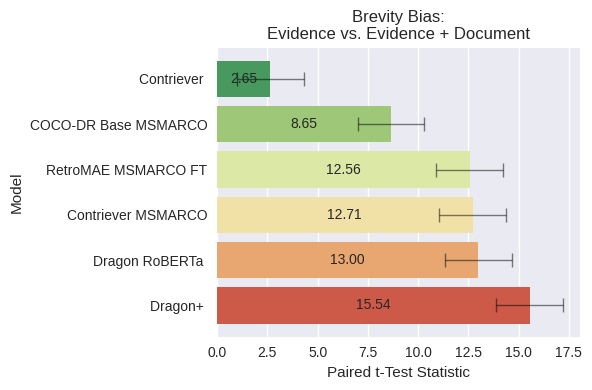

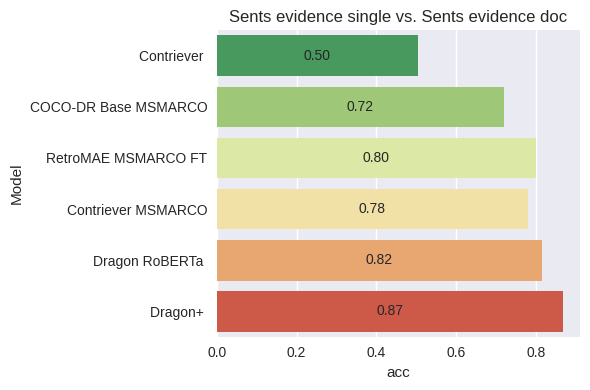

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low_stats,ttest_ci_high_stats,ttest_ci_low,ttest_ci_high,standard_ttest_ppf,acc,mean_diff,std_diff,n
0,Contriever,facebook/contriever_sents_evidence_single_dot,facebook/contriever_sents_evidence_doc_dot,2.653833,8.470639e-03,0.004853,0.032787,1.650996,1.650996,-1.650996,0.504,0.018820,0.112127,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_evidence_single_dot,OpenMatch/cocodr-base-msmarco_sents_evidence_doc_dot,8.650941,6.409187e-16,0.789708,1.255286,1.650996,1.650996,-1.650996,0.720,1.022497,1.868825,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_single_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_doc_dot,12.564399,2.273360e-28,2.033047,2.788916,1.650996,1.650996,-1.650996,0.800,2.410981,3.034046,250
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_evidence_single_dot,facebook/contriever-msmarco_sents_evidence_doc_dot,12.707058,7.529058e-29,0.093560,0.127883,1.650996,1.650996,-1.650996,0.780,0.110721,0.137771,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_evidence_single_dot,facebook/dragon-roberta-query-encoder_sents_evidence_doc_dot,12.997666,7.866896e-30,1.953694,2.651522,1.650996,1.650996,-1.650996,0.816,2.302608,2.801074,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_evidence_single_dot,facebook/dragon-plus-query-encoder_sents_evidence_doc_dot,15.541415,1.562510e-38,2.379123,3.069634,1.650996,1.650996,-1.650996,0.868,2.724378,2.771704,250


In [16]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and sents_cols[0] in col1:
                ttest = stats.ttest_rel(df[col1], df[col2])
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": ttest[0],
                    "ttest_pvalue": ttest[1],
                    "ttest_ci_low_stats": ttest.confidence_interval(confidence_level=0.95)[0],
                    "ttest_ci_high_stats": ttest.confidence_interval(confidence_level=0.95)[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "standard_ttest_ppf": standard_ttest_ppf(len(df)),
                    "acc": (df[col1] > df[col2]).mean(),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"Brevity Bias:\nEvidence vs. Evidence + Document")
results_df.to_json("results/brevity_df.json", orient="records")
ax = sns.barplot(
    data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig("figs/brevity_ttest.pdf")
plt.show()

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"{sents_cols[0].replace('_', ' ').capitalize()} vs. {sents_cols[1].replace('_', ' ').capitalize()}")
ax = sns.barplot(
    data=results_df, y="Model", x="acc", palette=sns.color_palette("RdYlGn_r"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig("figs/tail_foil_ttest.pdf")

results_df

In [39]:
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n
0,Contriever,11.199539,0.113281,0.123880,150
0,COCO-DR Base MSMARCO,17.272446,4.323387,3.065603,150
0,Contriever MSMARCO,20.791762,0.351577,0.207098,150
0,Dragon RoBERTa,21.994042,7.331820,4.082746,150
0,Dragon+,23.227364,8.608004,4.538874,150
0,RetroMAE MSMARCO FT,23.501528,9.599994,5.002884,150


In [44]:
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n
0,Contriever,32.705329,0.125117,0.120976,1000
0,COCO-DR Base MSMARCO,44.269212,4.495484,3.211254,1000
0,Contriever MSMARCO,59.360253,0.351754,0.187389,1000
0,RetroMAE MSMARCO FT,59.691034,9.688393,5.132662,1000
0,Dragon RoBERTa,66.031718,8.210115,3.931847,1000
0,Dragon+,74.939643,9.578639,4.041961,1000


In [48]:
results_df["t"] = results_df.apply(lambda r: r["mean_diff"]/r["std_diff"]*np.sqrt(r['n']), axis=1)
results_df["tm"] = results_df.apply(lambda r: r["mean_diff"]/r["std_diff"], axis=1)
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n", "t", "tm"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n,t,tm
0,Contriever,32.705329,0.125117,0.120976,1000,32.705326,1.034233
0,COCO-DR Base MSMARCO,44.269212,4.495484,3.211254,1000,44.269211,1.399915
0,Contriever MSMARCO,59.360253,0.351754,0.187389,1000,59.360253,1.877136
0,RetroMAE MSMARCO FT,59.691034,9.688393,5.132662,1000,59.691031,1.887596
0,Dragon RoBERTa,66.031718,8.210115,3.931847,1000,66.031721,2.088106
0,Dragon+,74.939643,9.578639,4.041961,1000,74.939651,2.369800
